<a href="https://colab.research.google.com/github/pedrogasg/models-katas/blob/master/Histogram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def sample_data_1():
    count = 10000
    rand = np.random.RandomState(0)
    a = 0.4 + 0.15 * rand.randn(count)
    b = 0.7 + 0.05 * rand.randn(count)
    mask = rand.rand(count) < 0.5
    samples = np.clip(a * mask + b * (1 - mask), 0.0, 1.0)
    data = np.digitize(samples, np.linspace(0.0, 1.0, 100))
    split = int(0.8 * len(data))
    train_data, test_data = data[:split], data[split:]
    return train_data, test_data

In [ ]:
def plot_data(train_data, test_data, bins=100):
  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.set_figheight(5)
  fig.set_figwidth(15)
  ax1.set_title('Train Data')
  ax1.hist(train_data, bins=np.arange(bins) - 0.5, density=True)
  ax1.set_xlabel('x')
  ax2.set_title('Test Data')
  ax2.hist(test_data, bins=np.arange(bins) - 0.5, density=True)
  plt.show()

In [ ]:
def plot_hist(data, bins=10, xlabel='x', ylabel='Probability', title='', density=None):
    bins = np.concatenate((np.arange(bins) - 0.5, [bins - 1 + 0.5]))

    plt.figure()
    plt.hist(data, bins=bins, density=True)

    if density:
        plt.plot(density[0], density[1], label='distribution')
        plt.legend()

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

In [ ]:
train_data, test_data  = sample_data_1()

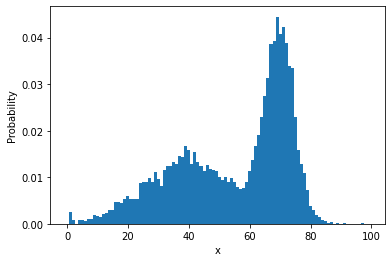

In [ ]:
plot_hist(train_data, bins=100)

In [ ]:
ds = tf.data.Dataset.from_tensor_slices(train_data)
ds = ds.shuffle(1000).batch(128, drop_remainder=True)

In [ ]:
class Histogram(tf.keras.layers.Layer):
  def __init__(self, d):
    super(Histogram, self).__init__()
    self.d = d
    self.logits = self.add_weight(shape=(d,), initializer="zeros", trainable=True)
    self.x = tf.Variable(initial_value=tf.linspace(-0.5, d - 0.5, 1000), trainable=False)
    self.cce = tf.keras.losses.SparseCategoricalCrossentropy()

  def call(self, inputs):
    y = tf.expand_dims(self.logits, axis=0)
    y = tf.tile(y,(inputs.shape[0],1))
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
          logits=y, labels=inputs
      ))
    return loss
  
  def get_density(self):
    y = tf.reshape(tf.tile(tf.expand_dims(tf.nn.softmax(self.logits, axis=0), axis=1), (1, 1000 // self.d)), [-1]).numpy()
    return self.x.numpy(), y



In [ ]:
def train(model, dataset, optimizer):
  model.trainable = True
  for x in dataset:
    with tf.GradientTape() as tape:
      loss = model(x)
      grads = tape.gradient(loss, model.trainable_weights)

      optimizer.apply_gradients(zip(grads, model.trainable_weights))

In [ ]:
d = 100
hist = Histogram(d)

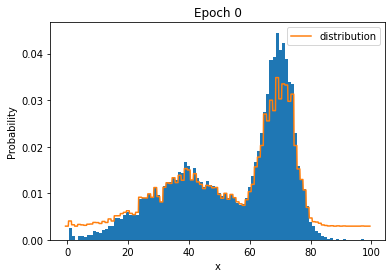

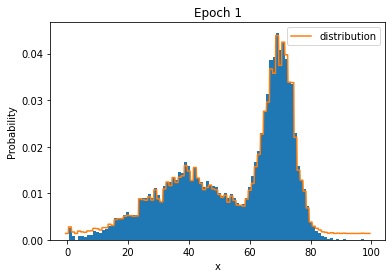

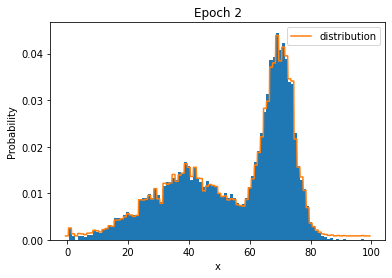

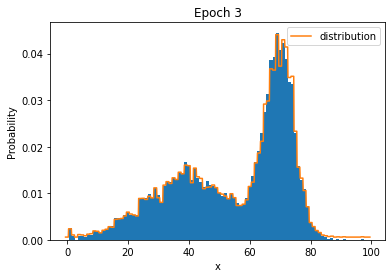

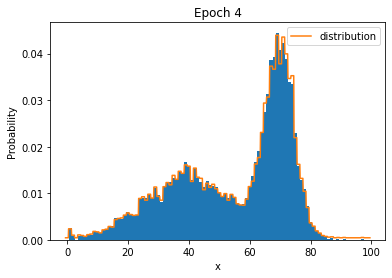

In [ ]:
epochs=5
lr=2.5e-2
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
for epoch in range(epochs):
  train(hist, ds, optimizer)
  plot_hist(train_data, bins=d,
                      title=f'Epoch {epoch}', density=hist.get_density())